<a href="https://colab.research.google.com/github/baptiste-bedouret/Spark/blob/master/Spark_Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark Mini Project

## Load Spark

In [ ]:
!pip install pyspark

In [2]:
import pyspark

In [3]:
# import os
# import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
spark = pyspark.sql.SparkSession.builder.appName('MiniProject').config("spark.executor.memory", "4g").getOrCreate()

In [5]:
spark

## Libraries

In [6]:
import pandas as pd
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import to_date, year, month, weekofyear, col, format_number, avg, date_format, when, round
import seaborn as sns
import matplotlib.pyplot as plt

## Data preparation - Step 1

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1- Read and merge all gas files

I downloaded from github all the gas files in format csv.gz and I used the linux command line `gunzip` to convert them to csv. Next step was to add them in Google drive which took me about 1 hour.

In [8]:
# Read the firt file and show the dataframe
gas_path1 = "/content/drive/My Drive/Smart-Data/Spark/Prix2019.csv"
dataf1 = spark.read.csv(gas_path1, sep = ';', header=False, inferSchema=True)

dataf1.show(5)
print("\n--------------\n")
dataf1.printSchema()

+-------+----+---+---------+--------+-------------------+---+------+----+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|  R|4620114.0|519791.0|2019-01-04 10:53:48|  1|Gazole|1328|
|1000001|1000|  R|4620114.0|519791.0|2019-01-07 10:25:25|  1|Gazole|1348|
|1000001|1000|  R|4620114.0|519791.0|2019-01-10 08:54:28|  1|Gazole|1374|
|1000001|1000|  R|4620114.0|519791.0|2019-01-11 10:01:54|  1|Gazole|1387|
|1000001|1000|  R|4620114.0|519791.0|2019-01-14 11:04:53|  1|Gazole|1394|
+-------+----+---+---------+--------+-------------------+---+------+----+
only showing top 5 rows


--------------

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: timestamp (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: string (nullable = true)
 

In the github page https://github.com/rvm-courses/GasPrices, all the informations that we need are gathered at the end of the page. The separators are also given.

In [9]:
# Read the other gas files

gas_path2 = "/content/drive/My Drive/Smart-Data/Spark/Prix2020.csv"
gas_path3 = "/content/drive/My Drive/Smart-Data/Spark/Prix2021.csv"
gas_path4 = "/content/drive/My Drive/Smart-Data/Spark/Prix2022S1.csv"
gas_path5 = "/content/drive/My Drive/Smart-Data/Spark/Prix2022S2.csv"
gas_path6 = "/content/drive/My Drive/Smart-Data/Spark/Prix2023.csv"
gas_path7 = "/content/drive/My Drive/Smart-Data/Spark/Stations2022.csv"
gas_path8 = "/content/drive/My Drive/Smart-Data/Spark/Services2022.csv"

dataf2 = spark.read.csv(gas_path2, sep = ';', header=False, inferSchema=True)
dataf3 = spark.read.csv(gas_path3, sep = ';', header=False, inferSchema=True)
dataf4 = spark.read.csv(gas_path4, sep = ';', header=False, inferSchema=True)
dataf5 = spark.read.csv(gas_path5, sep = ';', header=False, inferSchema=True)
dataf6 = spark.read.csv(gas_path6, sep = ';', header=False, inferSchema=True)
dataf7 = spark.read.csv(gas_path7, sep = '|', header=False, inferSchema=True)
dataf8 = spark.read.csv(gas_path8, sep = '|', header=False, inferSchema=True)

Here I created a function that rename the columns to be able to do some further processing and to understand better on what we are working on.

In [10]:
# Rename the columns for further process and visualization

def rename_columns_price(df):
    return (
        df
        .withColumnRenamed("_c0", "id_pdv")
        .withColumnRenamed("_c1", "zip_code")
        .withColumnRenamed("_c2", "pop")
        .withColumnRenamed("_c3", "latitude")
        .withColumnRenamed("_c4", "longitude")
        .withColumnRenamed("_c5", "date")
        .withColumnRenamed("_c6", "gas_id")
        .withColumnRenamed("_c7", "gas_label")
        .withColumnRenamed("_c8", "price")
    )

df1 = rename_columns_price(dataf1)
df2 = rename_columns_price(dataf2)
df3 = rename_columns_price(dataf3)
df4 = rename_columns_price(dataf4)
df5 = rename_columns_price(dataf5)
df6 = rename_columns_price(dataf6)

# Rename columns for stations file

df7 =(
        dataf7
        .withColumnRenamed("_c0", "id_pdv")
        .withColumnRenamed("_c1", "zip_code")
        .withColumnRenamed("_c2", "pop")
        .withColumnRenamed("_c3", "latitude")
        .withColumnRenamed("_c4", "longitude")
        .withColumnRenamed("_c5", "adress")
        .withColumnRenamed("_c6", "city")
    )

# Rename columns for services file

df8 =(
        dataf8
        .withColumnRenamed("_c0", "id_pdv")
        .withColumnRenamed("_c1", "zip_code")
        .withColumnRenamed("_c2", "pop")
        .withColumnRenamed("_c3", "latitude")
        .withColumnRenamed("_c4", "longitude")
        .withColumnRenamed("_c5", "services")
    )

In [11]:
# Show some of the dataframe to see how they are build
df7.show(5)
df7.printSchema()
print("\n--------------\n")
df8.show(5)
df8.printSchema()

+-------+--------+---+-------------+-------------+--------------------+--------------------+
| id_pdv|zip_code|pop|     latitude|    longitude|              adress|                city|
+-------+--------+---+-------------+-------------+--------------------+--------------------+
|1000001|    1000|  R|    4620100.0|     519800.0|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|1000002|    1000|  R|    4621842.0|     522767.0| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|1000004|    1000|  R|    4618800.0|     524500.0|20 Avenue du Maré...|     Bourg-en-Bresse|
|1000005|    1000|  R|4620093.59235|519942.024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|1000006|    1000|  R|    4620754.0|     523758.0|1 Boulevard John ...|     BOURG-EN-BRESSE|
+-------+--------+---+-------------+-------------+--------------------+--------------------+
only showing top 5 rows

root
 |-- id_pdv: integer (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: dou

I realized that the values in the columns `price` in the dataframes from 2022 to 2023 are not in the same representation than the ones in the previous years. So my idea was to multiply the values by 1000 to have them in the same range as the others.

In [12]:
# Normalized the column 'price' for the years 2022 and 2023

# Multiply the values in the 'price' column by 1000
df4 = df4.withColumn("price", col("price") * 1000)
df5 = df5.withColumn("price", col("price") * 1000)
df6 = df6.withColumn("price", col("price") * 1000)

df4.show(5)

+-------+--------+---+---------+---------+-------------------+------+---------+------+
| id_pdv|zip_code|pop| latitude|longitude|               date|gas_id|gas_label| price|
+-------+--------+---+---------+---------+-------------------+------+---------+------+
|1000001|    1000|  R|4620100.0| 519800.0|2022-01-03 08:44:18|     1|   Gazole|1572.0|
|1000001|    1000|  R|4620100.0| 519800.0|2022-01-05 10:08:11|     1|   Gazole|1560.0|
|1000001|    1000|  R|4620100.0| 519800.0|2022-01-10 10:09:08|     1|   Gazole|1603.0|
|1000001|    1000|  R|4620100.0| 519800.0|2022-01-17 12:34:42|     1|   Gazole|1616.0|
|1000001|    1000|  R|4620100.0| 519800.0|2022-01-17 12:34:44|     1|   Gazole|1616.0|
+-------+--------+---+---------+---------+-------------------+------+---------+------+
only showing top 5 rows



Here was a tricky phase because the objective was to merge all the gas files.
First of all, I concatenated all the dataframes from the price files. Indeed, they have the same columns so it wasn't difficult.

In [13]:
# Concatenate all the price files

# list of the prices dataframes
frames = [df1, df2, df3, df4, df5, df6]

# create merged dataframe
df_concat = reduce(DataFrame.union, frames)

# See if it has been well concatenated
# df_concat.show(5)
print("\n--------------\n")
# df_concat.tail(5)


--------------



Finally, I used the outer join which allows us to create a join between 2 tables. By using this command, we can combine the results of 2 tables, associate them with a condition and fill with NULL values if the condition is not met.

So I used this command to join the **service dataframe** with the **concatenated price dataframe** to be able to combine the results where columns in both table are similar and add the service's columns if they are new. (Same for station dataframe). `df_final` is the generated result.

In [14]:
# Merge the gas files with the outer join

common_columns=["id_pdv", "zip_code", "pop", "latitude", "longitude"]
df_join = df_concat.join(df7, on=common_columns, how="outer")
df_final = df_join.join(df8, on=common_columns, how="outer")

# df_join.show(5)
print("\n--------------\n")
# df_final.show(5)


--------------



### 2- Split date in year, month, week of the year

Next was to split the date into year, month and week. I used for that `pyspark.sql.functions` which contains the necessary tools to be able to manage pyspark dataframes.

In [15]:
# Split date in year, month and week

df_final = df_final.withColumn("timestamp", to_date(col("date")))
df_final = df_final.withColumn("year", year("timestamp"))
df_final = df_final.withColumn("month", month("timestamp"))
df_final = df_final.withColumn("week_of_year", weekofyear("timestamp"))

# df_final.show(5)

### 3- Prepare latitude & longitude for mapping

We want the latitude and longitude to be normalized for mapping. So I divided by the right power of 10 to have the coordinates in the right shape. For example, for the first row, we have latitude: 46.188 and longitude: 5.245 which is located in Bourg-en-Bresse. Then we check if in the column 'city' we have match the right city for the new latitude and longitude. It is correct.

In [16]:
# Normalize latitude and longitude by dividing by 10^5

df_final = df_final.withColumn("latitude", col("latitude") / 1e5)
df_final = df_final.withColumn("longitude", col("longitude") / 1e5)
df_final.show(5)

+-------+--------+---+--------+---------+-------------------+------+---------+------+--------------------+---------------+--------------------+----------+----+-----+------------+
| id_pdv|zip_code|pop|latitude|longitude|               date|gas_id|gas_label| price|              adress|           city|            services| timestamp|year|month|week_of_year|
+-------+--------+---+--------+---------+-------------------+------+---------+------+--------------------+---------------+--------------------+----------+----+-----+------------+
|1000004|    1000|  R|  46.188|    5.245|2019-01-04 20:00:00|     1|   Gazole|1440.0|20 Avenue du Maré...|Bourg-en-Bresse|Toilettes publiqu...|2019-01-04|2019|    1|           1|
|1000004|    1000|  R|  46.188|    5.245|2020-01-13 13:24:25|     1|   Gazole|1570.0|20 Avenue du Maré...|Bourg-en-Bresse|Toilettes publiqu...|2020-01-13|2020|    1|           3|
|1000004|    1000|  R|  46.188|    5.245|2022-01-05 14:55:02|     1|   Gazole|1670.0|20 Avenue du Maré...

### 4- Consider which gas types have some interest

Through basic statistics I counted the number of distinct labels. I found 6 differents and I printed them. Then I processed by taking the gas label which are the least used in the dataframe. At the end, I removed from the dataframe the gas **E85** and **GPLc**.  
   

In [17]:
# Filtered out the least interesting gas labels

# Count the number of distinct labels in the column
# gas_label_counts = df_final.select("gas_label").distinct().count()
# print("Number of distinct gas labels:", gas_label_counts)

# Show what type of gas is used the most
label_counts = df_final.groupBy('gas_label').count()

# Show the average price for the differents gas label
df_final.groupBy('gas_label').agg({'price' : 'mean'}).show()

# Order the labels by count in descending order
ordered_labels = label_counts.orderBy(col("count").desc())
print("\n--------------\n")
ordered_labels.show()

+---------+------------------+
|gas_label|        avg(price)|
+---------+------------------+
|      E10|1628.2735824341332|
|     SP98|1711.4808162481872|
|     NULL|              NULL|
|      E85| 841.5766589033335|
|   Gazole|1597.1511167788422|
|     SP95|1640.5968886100468|
|     GPLc| 898.2909415397596|
+---------+------------------+


--------------

+---------+-------+
|gas_label|  count|
+---------+-------+
|   Gazole|6671688|
|     SP98|5543363|
|      E10|5534734|
|     SP95|1641710|
|      E85|1620438|
|     GPLc| 957591|
|     NULL|  18882|
+---------+-------+



In [18]:
# Define the labels to be removed
labels_to_remove = ["NULL", "E85", "GPLc"]

# Filter out the rows containing the two least used labels
df_final = df_final.filter(~df_final['gas_label'].isin(labels_to_remove))

## Data preparation - Step 2

### 1- Compute price index for each station per week

For this step I computed the variable `avg_price_france` by grouping the DataFrame df_final based on the values in the "gas_label" and "date" columns. After grouping, I used the 'agg' function to aggregate the data. It calculates the average 'avg' of the "price" column for each group. The result is a new column named "avg_day_price_france" containing the average price for each gas label.

In [19]:
# Calculate the average daily price for each gas type in France
avg_price_france = (
    df_final
    .groupBy("gas_label", "timestamp")
    .agg(avg("price").alias("avg_day_price_france"))
    .orderBy("timestamp")
)
avg_price_france.show(5)

+---------+----------+--------------------+
|gas_label| timestamp|avg_day_price_france|
+---------+----------+--------------------+
|      E10|2019-01-01|  1410.8494368701838|
|   Gazole|2019-01-01|  1424.2279582366589|
|     SP98|2019-01-01|  1507.4599348534202|
|     SP95|2019-01-01|  1493.2641509433963|
|     SP98|2019-01-02|  1478.8105906313647|
+---------+----------+--------------------+
only showing top 5 rows



In [20]:
df_final = (
    df_final
    .join(avg_price_france, on=["gas_label", "timestamp"], how="left")
    .withColumn('price_index', 100 * ((col("price") - col("avg_day_price_france")) / col("avg_day_price_france")) + 1)
)
df_final.show(5)

+---------+----------+-------+--------+---+--------+---------+-------------------+------+------+------+----+--------+----+-----+------------+--------------------+--------------------+
|gas_label| timestamp| id_pdv|zip_code|pop|latitude|longitude|               date|gas_id| price|adress|city|services|year|month|week_of_year|avg_day_price_france|         price_index|
+---------+----------+-------+--------+---+--------+---------+-------------------+------+------+------+----+--------+----+-----+------------+--------------------+--------------------+
|   Gazole|2019-01-07|1000001|    1000|  R|46.20114|  5.19791|2019-01-07 10:25:25|     1|1348.0|  NULL|NULL|    NULL|2019|    1|           2|   1388.583114150447| -1.9226276581417538|
|   Gazole|2019-01-04|1000001|    1000|  R|46.20114|  5.19791|2019-01-04 10:53:48|     1|1328.0|  NULL|NULL|    NULL|2019|    1|           1|  1386.5670557146002|  -3.223889170972426|
|   Gazole|2019-01-14|1000001|    1000|  R|46.20114|  5.19791|2019-01-14 11:04:5

This formula calculates the percentage difference between the price at a specific station for a gas type and the average daily price for that gas type in France. The result is multiplied by 100 to express it as a percentage, and 1 is added to the final value.

In [21]:
df_final.describe('price_index').show()

+-------+------------------+
|summary|       price_index|
+-------+------------------+
|  count|          19391495|
|   mean|1.0000000000000375|
| stddev| 4.883811569550836|
|    min|-98.94902330059968|
|    max| 498.9728924930767|
+-------+------------------+



### 2- Compute week index

In [22]:
# Calculate the number of weeks since the first week in the file
min_week = df_final.selectExpr("min(week_of_year)").collect()[0][0]
df_final = df_final.withColumn("week_index", (col("year") - 2019) * 53 + col("week_of_year"))

In [23]:
df_final.describe('week_index').show()

+-------+------------------+
|summary|        week_index|
+-------+------------------+
|  count|          19391495|
|   mean|135.26360953603628|
| stddev|  76.7031711324586|
|    min|                 1|
|    max|               264|
+-------+------------------+



## Data Visualization

I represented the weekly evolution of average gas price over France.

In [24]:
# Group by gas_label, week_index, and calculate average price for each week
avg_price_weekly = (
    df_final
    .groupBy("gas_label", "week_index")
    .agg(avg("avg_day_price_france").alias("avg_price_weekly"))
    .orderBy("week_index")
)
avg_price_weekly.show(5)

# Convert PySpark DataFrame to Pandas for Seaborn plotting
avg_price_weekly_pd = avg_price_weekly.toPandas()

+---------+----------+------------------+
|gas_label|week_index|  avg_price_weekly|
+---------+----------+------------------+
|     SP98|         1| 1518.494630392046|
|     SP95|         1|1455.3585618355144|
|      E10|         1| 1431.217237308209|
|   Gazole|         1| 1424.799673481608|
|     SP95|         2|  1424.39989792006|
+---------+----------+------------------+
only showing top 5 rows



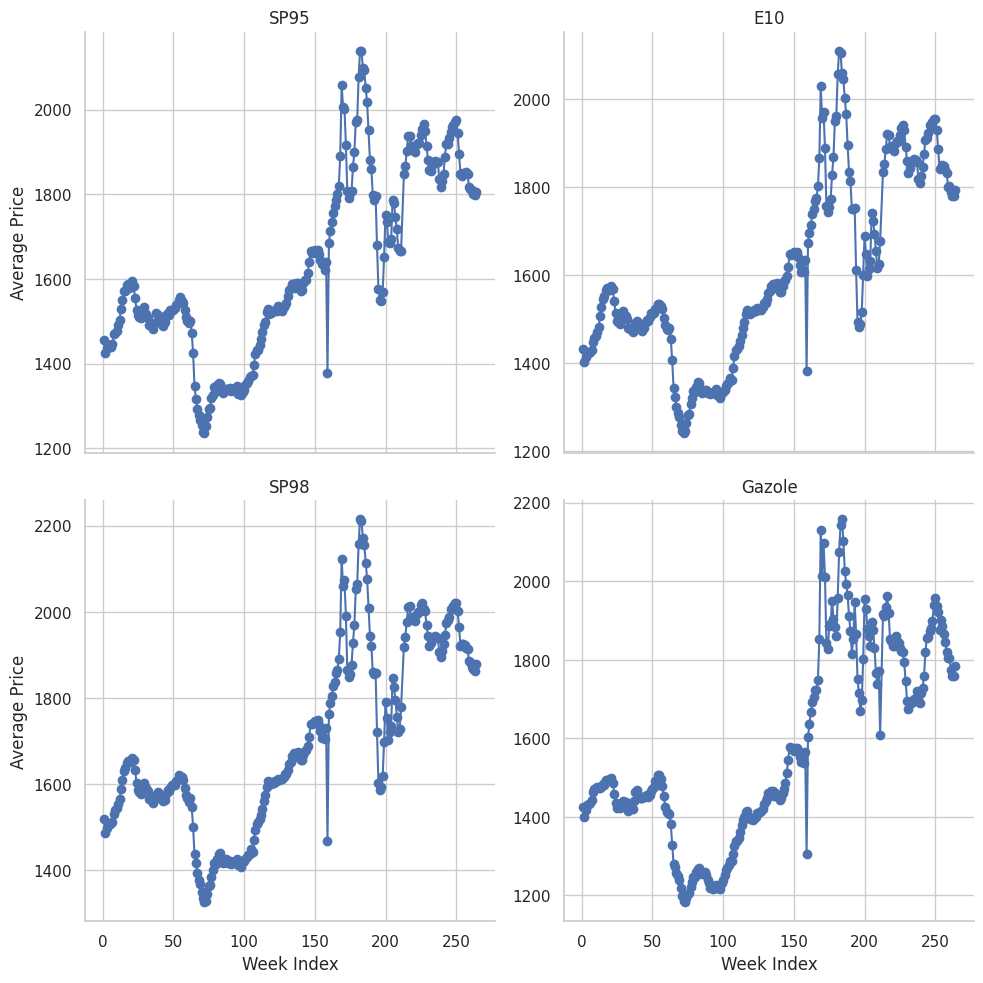

In [25]:
# Plot using Seaborn FacetGrid
sns.set(style="whitegrid")
g = sns.FacetGrid(avg_price_weekly_pd, col="gas_label", col_wrap=2, height=5, sharey=False)
g.map(plt.plot, "week_index", "avg_price_weekly", marker="o", linestyle="-")
g.set_axis_labels("Week Index", "Average Price")
g.set_titles(col_template="{col_name}")
plt.show()

In the plot above we can see that the average price for the different type of gas are quite similar. We can denote the same trend for each of them depending on the week index. These plots seems to be correct. We can see that their are increasing troughout the weeks (the years). Between 2022 and 2023 we denote large variations because of severals factors. The inflations, the price of the barrel of oil, the war between Ukraine and Russia and others several aspects.

In [26]:
df_final = (
    df_final
    .join(avg_price_weekly, on=["gas_label", "week_index"], how="left")
)
df_final.show(5)

+---------+----------+----------+-------+--------+---+--------+---------+-------------------+------+------+------+----+--------+----+-----+------------+--------------------+--------------------+------------------+
|gas_label|week_index| timestamp| id_pdv|zip_code|pop|latitude|longitude|               date|gas_id| price|adress|city|services|year|month|week_of_year|avg_day_price_france|         price_index|  avg_price_weekly|
+---------+----------+----------+-------+--------+---+--------+---------+-------------------+------+------+------+----+--------+----+-----+------------+--------------------+--------------------+------------------+
|   Gazole|         2|2019-01-07|1000001|    1000|  R|46.20114|  5.19791|2019-01-07 10:25:25|     1|1348.0|  NULL|NULL|    NULL|2019|    1|           2|   1388.583114150447| -1.9226276581417538|1399.0902171156054|
|   Gazole|         2|2019-01-11|1000001|    1000|  R|46.20114|  5.19791|2019-01-11 10:01:54|     1|1387.0|  NULL|NULL|    NULL|2019|    1|     

## Modeling – Forecast next day price

Target variable (y): `price`

Variables to be used as predictors:
* Lagged Prices
* id pdv
* gas_label (removed since it doesn't work because of java heap out of memory)
* week_index
* gas_id
* average_day_france
* price_index (removed since it doesn't work because of java heap out of memory)

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer

In [28]:
# Define the lag window specification
lag_window = Window.partitionBy("gas_label").orderBy("date")

# Include lag features for the last three days
for i in range(1, 3):
    lag_col = f"lag_price_{i}"
    df_final = df_final.withColumn(lag_col, F.lag(col("price"), i).over(lag_window))

This code creates lag features ("lag_price_1", "lag_price_2") based on the "price" column for the last two days.

I added the new columns to the dataFrame called 'lag_price_i'. The `lag` function is used to get the value of the column 'price' in the previous row. It looks back '$i$' rows where '$i$' is the lag value.

By including lag features, the model should be better to capture the next day price for a gas type in a station.

In [29]:
df_final.printSchema()

root
 |-- gas_label: string (nullable = true)
 |-- week_index: integer (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- id_pdv: integer (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- adress: string (nullable = true)
 |-- city: string (nullable = true)
 |-- services: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- avg_day_price_france: double (nullable = true)
 |-- price_index: double (nullable = true)
 |-- avg_price_weekly: double (nullable = true)
 |-- lag_price_1: double (nullable = true)
 |-- lag_price_2: double (nullable = true)



I then converted the columns from double to integer because integer values typically require less memory compared to double-precision floating-point values. But the downside is that we can loose precision when evaluating the model.

In [30]:
# Convert columns from double to integer
df_final = df_final.withColumn("price", col("price").cast("integer"))
df_final = df_final.withColumn("lag_price_1", col("lag_price_1").cast("integer"))
df_final = df_final.withColumn("lag_price_2", col("lag_price_2").cast("integer"))
df_final = df_final.withColumn("avg_day_price_france", col("avg_day_price_france").cast("integer"))
df_final = df_final.withColumn("avg_price_weekly", col("avg_price_weekly").cast("integer"))

In [31]:
# Round the values in the columns below to two decimal places
df_final = df_final.withColumn("price_index", round(col("price_index"), 2))

In [32]:
df_final.printSchema()

root
 |-- gas_label: string (nullable = true)
 |-- week_index: integer (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- id_pdv: integer (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- adress: string (nullable = true)
 |-- city: string (nullable = true)
 |-- services: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- avg_day_price_france: integer (nullable = true)
 |-- price_index: double (nullable = true)
 |-- avg_price_weekly: integer (nullable = true)
 |-- lag_price_1: integer (nullable = true)
 |-- lag_price_2: integer (nullable = true)



All the columns have nullable = true meaning that the corresponding column in my dataFrame allows null values.

Drop rows which contain missing values :

In [33]:
# Drop rows with missing values
df_final = df_final.na.drop()
df_final.show()

+---------+----------+----------+-------+--------+---+-----------------+-----------------+-------------------+------+-----+--------------------+--------------------+--------------------+----+-----+------------+--------------------+-----------+----------------+-----------+-----------+
|gas_label|week_index| timestamp| id_pdv|zip_code|pop|         latitude|        longitude|               date|gas_id|price|              adress|                city|            services|year|month|week_of_year|avg_day_price_france|price_index|avg_price_weekly|lag_price_1|lag_price_2|
+---------+----------+----------+-------+--------+---+-----------------+-----------------+-------------------+------+-----+--------------------+--------------------+--------------------+----+-----+------------+--------------------+-----------+----------------+-----------+-----------+
|      E10|         1|2019-01-01|1000013|    1000|  R|    46.1985183794|5.243506378809999|2019-01-01 00:01:00|     5| 1319|BOULEVARD CHARLES...| 

The code below is part of a feature engineering process for preparing the features for the machine learning model. I used the function `StringIndexer` that converts the categorical column 'gas_label' (string) into a numerical index and outputs the result in a new column called 'gas_label_index'.

`One-hot encoding` is used to convert categorical indices obtained from the String Indexer into binary vectors. For each distinct value in the categorical column, a binary column is created, indicating the presence or absence of that value.

The `VectorAssembler` takes the specified input columns (both numerical and one-hot encoded) and combines them into a single vector column named 'features'. This 'features' column will be the input to my model.

In [34]:
# 1. Feature Vectorization

# String indexer: string -> number
# OneHotEncoder: number -> set of columns
# Imputer: replace missing values

# gas_label_indexer = StringIndexer(inputCol='gas_label', outputCol='gas_label_index')
# gas_label_encoder = OneHotEncoder(inputCol='gas_label_index', outputCol='gas_label_onehot')
# id_pdv_encoder = OneHotEncoder(inputCol='id_pdv', outputCol='id_pdv_onehot')
# gas_id_encoder = OneHotEncoder(inputCol='gas_id', outputCol='gas_id_onehot')

gas_id_encoder = OneHotEncoder(inputCol='gas_id', outputCol='gas_id_onehot')

feature_columns = ["lag_price_1", "lag_price_2", "id_pdv", "gas_id_onehot",
                   "week_index", "avg_day_price_france"
                  ]
op_features = VectorAssembler(inputCols=feature_columns, outputCol='features')

I had problems with Java heap space which was out of memory. I struggled a lot to resolve this error. This was solve by reducing the amount of data in the dataframes by deleting the rows which contained NULL values. Moreover, instead of using the whole columns of the `df_final` dataframe for fitting the model, I used only the relevant features such as `lag_features`, `average_day_price` etc...
Finally, in the first part of the notebook where I start the construction of a Spark session, I wrote this line:
```
.config("spark.executor.memory", "4g")
```
This line of code allows to increase the amount of memory allocated to the Spark driver.

Now, this part is for training the model. I splitted the data into train set and test set and I used linear Regression to  to forecast the next day price for a gas type.

In [35]:
# 2. Model Training

# Split the data into training and testing sets
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=123)

# Build Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='price')

# Create Model RandomForestRegressor
# rf = RandomForestRegressor(labelCol="price", featuresCol="features", numTrees=10)

# Create a pipeline
pipeline = Pipeline(stages=[gas_id_encoder, op_features, lr])

# Train the model
model = pipeline.fit(train_data)

# We can look what inside the pipeline
model.stages[-1]

Py4JJavaError: An error occurred while calling o324.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 192.0 failed 1 times, most recent failure: Lost task 2.0 in stage 192.0 (TID 1394) (0a560ce1891b executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage43.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.fetchNextRow(WindowExec.scala:118)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.<init>(WindowExec.scala:127)
	at org.apache.spark.sql.execution.window.WindowExec.$anonfun$doExecute$3(WindowExec.scala:107)
	at org.apache.spark.sql.execution.window.WindowExec$$Lambda$4790/0x00000008417e2840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.RDD$$Lambda$2978/0x00000008412c6c40.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.execution.SQLExecutionRDD$$Lambda$2992/0x00000008412fac40.apply(Unknown Source)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1199)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1193)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1286)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1253)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1239)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1239)
	at org.apache.spark.ml.feature.OneHotEncoderCommon$.getOutputAttrGroupFromData(OneHotEncoder.scala:521)
	at org.apache.spark.ml.feature.OneHotEncoder.fit(OneHotEncoder.scala:196)
	at org.apache.spark.ml.feature.OneHotEncoder.fit(OneHotEncoder.scala:128)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage43.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.fetchNextRow(WindowExec.scala:118)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.<init>(WindowExec.scala:127)
	at org.apache.spark.sql.execution.window.WindowExec.$anonfun$doExecute$3(WindowExec.scala:107)
	at org.apache.spark.sql.execution.window.WindowExec$$Lambda$4790/0x00000008417e2840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.RDD$$Lambda$2978/0x00000008412c6c40.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.execution.SQLExecutionRDD$$Lambda$2992/0x00000008412fac40.apply(Unknown Source)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)


My code is good and I don't know why I still have this error. With other people it works but not with me. I honestly don't understand.

In [ ]:
# 3. Model Evaluation

# Make predictions on the test set
predictions = model.transform(test_data)
predictions.show(5, truncate = False)

I evaluate the performance the regression model by using the function `RegressionEvaluator` from the library pyspark.ml.evaluation. We use 'price' column as the true labels (ground truth) and the 'prediction' column as the predicted labels and Root Mean Squared Error (RMSE) as the evaluation metric.

In [ ]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions) # We evaluate the test dataset on the fitting trained dataset
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# 4. Prediction on a given gas type and station

station_to_predict = '17350001'
gas_label_to_predict = 'Gazole' # price -> 2.027

# Filter new_data for the specific station and gas type
new_data_for_prediction = df_final.filter((col("id_pdv") == station_to_predict) & (col("gas_label") == gas_label_to_predict))

# Make predictions on the filtered new data
new_predictions = model.transform(new_data_for_prediction)

# Show the predictions
predictions.select('lag_price_1', 'lag_price_2', 'id_pdv', 'week_index', 'gas_id_onehot', 'avg_day_price_france', 'prediction').show()

In [ ]:
# 5. Dispersion Plot
actual_vs_predicted = predictions.select('price', 'prediction').toPandas()
plt.scatter(actual_vs_predicted['price'], actual_vs_predicted['prediction'], color='blue', label='Actual vs. Predicted')
plt.plot([min(actual_vs_predicted['price']), max(actual_vs_predicted['price'])], [min(actual_vs_predicted['price']), max(actual_vs_predicted['price'])], linestyle='--', color='red', label='Perfect Prediction Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()